In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [38]:
df=pd.read_csv('Sleep_Efficiency.csv')
df=df.drop(['ID','Age','Gender','Bedtime','Wakeup time','Sleep duration','REM sleep percentage','Deep sleep percentage','Light sleep percentage','Awakenings','Smoking status'],axis=1)
df['Caffeine consumption']=df['Caffeine consumption'].fillna(1000)
df['Alcohol consumption']=df['Alcohol consumption'].fillna(0)
df['Exercise frequency']=df['Exercise frequency'].fillna(3)
df.head()


,Sleep efficiency,Caffeine consumption,Alcohol consumption,Exercise frequency
0,0.88,0.0,0.0,3.0
1,0.66,0.0,3.0,3.0
2,0.89,0.0,0.0,3.0
3,0.51,50.0,5.0,1.0
4,0.76,0.0,3.0,3.0


Linear Regression

In [39]:
from sklearn.model_selection import cross_val_score

y_target=df['Sleep efficiency']
X_data=df.drop(['Sleep efficiency'], axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=156)

#선형회귀 OLS로 학습/예측/평가 수행
lr=LinearRegression()
lr.fit(X_train, y_train)
y_preds=lr.predict(X_test)
mse=mean_squared_error(y_test, y_preds)
rmse=np.sqrt(mse)

print("MSE: {0:3f}, RMSE:{1:.3F}".format(mse,rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test,y_preds)))

neg_mse_scores=cross_val_score(lr, X_data, y_target, scoring="neg_mean_squared_error",cv=5)
rmse_scores=np.sqrt(-1*neg_mse_scores)
avg_rmse=np.mean(rmse_scores)

print('5 folds individual Negative MSE scores:',np.round(neg_mse_scores,2))
print('5 folds individual RMSE scores:',np.round(rmse_scores,2))
print('5 folds average RMSE: {0:.7f} '.format(avg_rmse))

coeff=pd.Series(data=np.round(lr.coef_,5), index=X_data.columns)
coeff.sort_values(ascending=False)


MSE: 0.014812, RMSE:0.122
Variance score : 0.113
5 folds individual Negative MSE scores: [-0.01 -0.02 -0.01 -0.02 -0.01]
5 folds individual RMSE scores: [0.12 0.12 0.12 0.13 0.11]
5 folds average RMSE: 0.1218303 


Exercise frequency      0.02447
Caffeine consumption    0.00000
Alcohol consumption    -0.03519
dtype: float64

Correlation

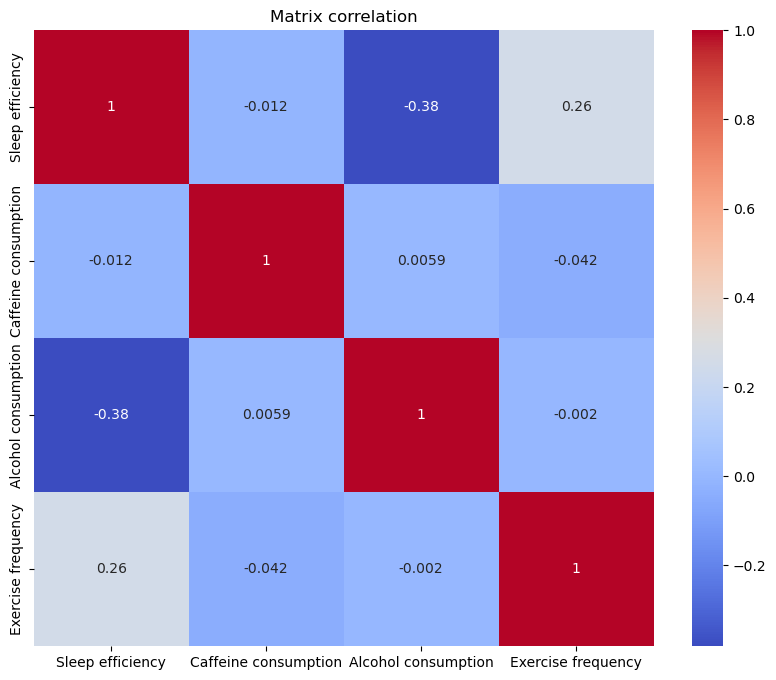

In [40]:
summary = df.describe()


# Matrice correlation
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Matrix correlation")
plt.show()


Ridge Regression

In [41]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
ridge=Ridge(alpha=10)
neg_mse_scores=cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error",cv=5)
rmse_scores=np.sqrt(-1*neg_mse_scores)
avg_rmse=np.mean(rmse_scores)
print("5 folds's each Negative MSE scores:",np.round(neg_mse_scores,3))
print("5 folds;s each RMSE scores:", np.round(rmse_scores,3))
print("Average RMSE: {0:.7f}".format(avg_rmse))

alphas=[0,0.1,1,10,100]
for alpha in alphas:
    ridge=Ridge(alpha=alpha)
    
coeff_df=pd.DataFrame()
for pos, alpha in enumerate(alphas):
    ridge=Ridge(alpha=alpha)
    ridge.fit(X_data, y_target)
    coeff=pd.Series(data=ridge.coef_,index=X_data.columns)
    colname='alpha:'+str(alpha)
    coeff_df[colname]=coeff
    coeff=coeff.sort_values(ascending=False)

ridge_alphas=[0,0.1,1,10,100]
sort_column='alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

5 folds's each Negative MSE scores: [-0.015 -0.015 -0.014 -0.018 -0.013]
5 folds;s each RMSE scores: [0.122 0.123 0.118 0.134 0.113]
Average RMSE: 0.1218315


,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
Exercise frequency,2.415590e-02,2.415327e-02,2.412958e-02,2.389520e-02,2.177975e-02
Caffeine consumption,5.646533e-07,5.638459e-07,5.565873e-07,4.847537e-07,-1.655872e-07
Alcohol consumption,-3.200305e-02,-3.200031e-02,-3.197570e-02,-3.173165e-02,-2.948146e-02


Lasso Regression

In [26]:
from sklearn.linear_model import Lasso, ElasticNet

def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True, return_coeff=True):
    coeff_df=pd.DataFrame()
    if verbose: print(model_name)
    for param in params:
        if model_name=='Ridge': model=Ridge(alpha=param)
        elif model_name=='Lasso': model=Lasso(alpha=param)
        elif moel_name=='ElasticNet': model=ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores=cross_val_score(model,X_data_n,y_target_n,scoring='neg_mean_squared_error',cv=5)
        avg_rmse=np.mean(np.sqrt(-1*neg_mse_scores))
        print('alpha{0}일 때 5폴드 세트의 평균 RMSE: {1:.3f}'.format(param,avg_rmse))
            
        model.fit(X_data_n,y_target_n)
        if return_coeff:
            coeff=pd.Series(data=model.coef_, index=X_data_n.columns)
            colname='alpha:'+str(param)
            coeff_df[colname]=coeff
    return coeff_df

lasso_alphas=[0.07,0.1,0.5,1,3]
coeff_lasso_df=get_linear_reg_eval('Lasso',params=lasso_alphas,X_data_n=X_data, y_target_n=y_target)
# 반환된 coeff_lasso_df를 첫번째 컬럼순으로 내림차순 정렬하여 회귀계수 DataFrame출력
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

Lasso
alpha0.07일 때 5폴드 세트의 평균 RMSE: 0.134
alpha0.1일 때 5폴드 세트의 평균 RMSE: 0.137
alpha0.5일 때 5폴드 세트의 평균 RMSE: 0.137
alpha1일 때 5폴드 세트의 평균 RMSE: 0.136
alpha3일 때 5폴드 세트의 평균 RMSE: 0.135


,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
Exercise frequency,0.000000,0.000000,0.0,0.0,0.0
Caffeine consumption,-0.000006,-0.000005,-0.0,-0.0,-0.0
Alcohol consumption,-0.004940,-0.000000,-0.0,-0.0,-0.0


최종결과:
상관관계 분석 결과, Sleep efficiency와 나머지 요소들의 상관관계가 높지는 않지만 그래도 의미를 부여하자면
운동 빈도의 경우 양의 상관관계를 가지지만 
알콜 섭취와 카페인 섭취의 경우 음의 상관관계를 가짐. 단, 상관관계 자체가 0에 가깝기 때문에 큰 의미를 가진다고 보기는 어려움.

회귀 모델 사용 결과:
RMSE를 기준으로 분석해보자면 LinearRegression->Ridge->Lasso 순이다.
LinearRegression 모델의 회귀 계수를 보자면, 양의 가중치에서는 운동 빈도가 가장 높게 나타났고 음의 가중치로는 알콜 섭취가 나타나였다.
사용자에게 수면 솔루션을 줄 때 카페인 섭취량, 운동 빈도, 알콜 섭취량을 얼마만큼 조절 했을 때 예상 수면 질을 보여주는 솔루션을 제공할 수 있다.